In [ ]:
from datasets import load_dataset, Dataset, Audio
import json
import os
import random


### https://huggingface.co/blog/mms_adapters
### https://huggingface.co/blog/fine-tune-xlsr-wav2vec2

### Load ALC to huggingface dataset

In [2]:
train_list = []
train_labels = []
val_list = []
val_labels = []
test_list = []
test_labels = []
data_dict = {}
data_path = '/data/ALC_corpus/'
for root, dirs, files in os.walk(data_path):
   for file in files:
      if file.endswith('h_00.wav') and not file.startswith('.'):
         data_dict[file] = os.path.join(root, file)
print(len(data_dict))

with open('./file_name_split/control_list_only.json', 'r') as f:
   control_l = json.load(f)
with open('./file_name_split/train_list.json', 'r') as f:
   train_l = json.load(f)
with open('./file_name_split/val_list.json', 'r') as f:
   val_l = json.load(f)
with open('./file_name_split/test_list.json', 'r') as f:
   test_l = json.load(f)

train_l = train_l + control_l
random.shuffle(train_l)

for file in train_l:
   train_list.append(data_dict[file])
   codes = [x for x in file]
   if codes[3] in ['1', '3']:
      train_labels.append(1)
   else:
      train_labels.append(0)
for file in val_l:
   val_list.append(data_dict[file])
   codes = [x for x in file]
   if codes[3] in ['1', '3']:
      val_labels.append(1)
   else:
      val_labels.append(0)
for file in test_l:
   test_list.append(data_dict[file])
   codes = [x for x in file]
   if codes[3] in ['1', '3']:
      test_labels.append(1)
   else:
      test_labels.append(0)
print(len(train_list))

14949
12078


In [3]:
train_dataset = Dataset.from_dict({'audio': train_list, 'label': train_labels}).cast_column("audio", Audio(sampling_rate=16_000))
val_dataset = Dataset.from_dict({'audio': val_list, 'label': val_labels}).cast_column("audio", Audio(sampling_rate=16_000))
test_dataset = Dataset.from_dict({'audio': test_list, 'label': test_labels}).cast_column("audio", Audio(sampling_rate=16_000))

In [4]:
import torch
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"device {device}")

#os.environ['CUDA_VISIBLE_DEVICES'] = '2'

from transformers import AutoFeatureExtractor

feature_extractor = AutoFeatureExtractor.from_pretrained("facebook/wav2vec2-large-xlsr-53")

device cuda


In [6]:
def preprocess_function(examples):
   audio_arrays = [x["array"] for x in examples["audio"]]
   max_length = max([len(x["array"]) for x in examples["audio"]])
   max_length = int(max_length *0.10)
   #print(max_length)
   inputs = feature_extractor(
      audio_arrays, sampling_rate=feature_extractor.sampling_rate, max_length=max_length, truncation=True
   )
   return inputs

encoded_train = train_dataset.map(preprocess_function, remove_columns="audio", batched=True)
encoded_val = val_dataset.map(preprocess_function, remove_columns="audio", batched=True)
encoded_test = test_dataset.map(preprocess_function, remove_columns="audio", batched=True)

In [7]:
import evaluate
accuracy = evaluate.load("accuracy")

import numpy as np
def compute_metrics(eval_pred):
    predictions = np.argmax(eval_pred.predictions, axis=1)
    return accuracy.compute(predictions=predictions, references=eval_pred.label_ids)

In [8]:


from transformers import Wav2Vec2Config, AutoModelForAudioClassification, TrainingArguments, Trainer
label2id = {'0':0,'1':1}
id2label = {0: '0', 1:'1'}
num_labels = len(id2label)
model = AutoModelForAudioClassification.from_pretrained("facebook/wav2vec2-large-xlsr-53", \
                                                        num_labels=num_labels, label2id=label2id, \
                                                        id2label=id2label, \
                                                        cache_dir = '/data/huggingface_cache_dir')


print(device) 
model.to(device)

Some weights of the model checkpoint at facebook/wav2vec2-large-xlsr-53 were not used when initializing Wav2Vec2ForSequenceClassification: ['project_hid.bias', 'quantizer.codevectors', 'quantizer.weight_proj.weight', 'project_q.bias', 'quantizer.weight_proj.bias', 'project_hid.weight', 'project_q.weight']
- This IS expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing Wav2Vec2ForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of Wav2Vec2ForSequenceClassification were not initialized from the model checkpoint at facebook/wav2vec2-large-xlsr-53 and are newly initialized: ['projector.bias', 'classifier.we

cuda


Wav2Vec2ForSequenceClassification(
  (wav2vec2): Wav2Vec2Model(
    (feature_extractor): Wav2Vec2FeatureEncoder(
      (conv_layers): ModuleList(
        (0): Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(1, 512, kernel_size=(10,), stride=(5,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (1-4): 4 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(3,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
        (5-6): 2 x Wav2Vec2LayerNormConvLayer(
          (conv): Conv1d(512, 512, kernel_size=(2,), stride=(2,))
          (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
          (activation): GELUActivation()
        )
      )
    )
    (feature_projection): Wav2Vec2FeatureProjection(
      (layer_norm): LayerNorm((512,), eps=1e-05, elementwise_affine=

In [ ]:
from transformers import TrainingArguments, Trainer
import transformers
transformers.utils.logging.set_verbosity_debug()




training_args = TrainingArguments(
    output_dir="alc_wav2vec_control",
    evaluation_strategy="epoch",
    save_strategy="epoch",
    learning_rate=1e-4,
    per_device_train_batch_size=1,
    gradient_accumulation_steps=32,
    per_device_eval_batch_size=1,
    num_train_epochs=10,
    warmup_ratio=0.1,
    logging_steps=1,
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    push_to_hub=False,
    disable_tqdm=False,
    fp16=True
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=encoded_train ,
    eval_dataset=encoded_test,
    tokenizer=feature_extractor,
    compute_metrics=compute_metrics,
)
trainer.train()
torch.save(model.state_dict(), "alc_wav2vec_1e4_with_control.params")

# Inference

In [10]:

in_values = encoded_test["input_values"]
in_labels = encoded_test["label"]


#for idx in range(len(encoded_val)):
#    data_entry = encoded_val[0]
#    print(data_entry)
#    pred_class = model(data_entry)

#torch.save(model.state_dict(), "alc_model_fine_tuned.params")

In [14]:
model.load_state_dict(torch.load('./alc_wav2vec_1e4_without_control.params'))
model.eval()

predicted = []
ground_truth = []
for idx in range(len(in_values)):
   data_entry = torch.tensor(in_values[idx]).to("cuda")
   data_label = in_labels[idx]

   data_entry = torch.unsqueeze(data_entry, 0)
   pred_class = model(data_entry)
   pred_logits = pred_class.logits
   pred_class = torch.softmax(pred_logits, 1)
   pred_class = torch.squeeze(pred_class)

   pred_class_index = torch.argmax(pred_class, 0)
   pred_class_index = int(pred_class_index.cpu().detach())

   predicted.append(pred_class_index)
   ground_truth.append(data_label)


### Analyse promts

In [23]:
read_a = ['001','003', '004', '006', '007', '008','009', '011', '012', '013', '015', '016', '017', '019','020','021','023','024','029','030'] #read numbers, address, words, sentences, credit card numbers, auto numbers
spontaneous_a = ['002', '014', '005','010','018'] 
command_control_a = ['022','025','026','027','028'] 

read_na = ['001','003','004','006','007','008','009','011','012','013','015', '016', '017', '019','020','021','023','024','026','027','028', '031','032','033','035','036','037','039','040','041','044','050','051','052','056','057','058','059','060']
spontaneous_na = ['002','014','022','034', '005', '010', '018','025','030','038'] 
command_control_na = ['042','043','045','046','047','048','049','053','054','055']

general_promts = []
promts = []
speakers = []

with open('./file_name_split/test_list.json','r') as file:
      test_list = json.load(file)
print(f'len test list: {len(test_list)}')
drunk = 0
sober = 0
for name in test_list:
      codes = [x for x in name]
      label = 1 if codes[3] in ['1', '3'] else 0
      promt = ''.join(codes[7:10])
      general_promts.append(promt)
      speaker = ''.join(codes[:3])
      speakers.append(speaker)
      if label == 1:
            drunk += 1
            if promt in read_a:
                  promts.append(0)
            elif promt in spontaneous_a:
                  promts.append(1)
            else:
                  promts.append(2)
      else:
            sober += 1
            if promt in read_na:
                  promts.append(0)
            elif promt in spontaneous_na:
                  promts.append(1)
            else:
                  promts.append(2)

print(drunk)
print(sober)



correct_idx = [idx for idx,val in enumerate(predicted) if ground_truth[idx]==val]
wrong_idx = [idx for idx,val in enumerate(predicted) if ground_truth[idx]!=val]

print(len(correct_idx))
print(len(wrong_idx))

correct_pr = [promts[idx] for idx in correct_idx]
wrong_pr = [promts[idx] for idx in wrong_idx]


print('total promts in test set')
prs, counts = torch.unique(torch.tensor(promts), return_counts=True)
# Print the unique values and their corresponding counts
for pr, count in zip(prs, counts):
    print(f"{pr}: {count}")

print('correct classified')
prs, counts = torch.unique(torch.tensor(correct_pr), return_counts=True)
# Print the unique values and their corresponding counts
for pr, count in zip(prs, counts):
    print(f"{pr}: {count}")

print('wrongly classified')
prs, counts = torch.unique(torch.tensor(wrong_pr), return_counts=True)
# Print the unique values and their corresponding counts
for pr, count in zip(prs, counts):
    print(f"{pr}: {count}")

len test list: 1436
486
950
1204
232
total promts in test set
0: 963
1: 225
2: 248
correct classified
0: 812
1: 183
2: 209
wrongly classified
0: 151
1: 42
2: 39


In [30]:
print(len(general_promts))
promt_list = [general_promts[idx] for idx in wrong_idx]
print(len(promt_list))
promt_dict = {sp: promt_list.count(sp) for sp in set(promt_list)}
print(len(promt_dict))
sorted_dict = dict(sorted(promt_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)

always_correct_promt = [pr for pr in general_promts if pr not in promt_list]
print(set(always_correct_promt))
print(len(set(always_correct_promt)))

1436
232
43
{'009': 13, '019': 12, '005': 11, '024': 10, '023': 9, '021': 9, '027': 8, '001': 8, '030': 8, '002': 8, '020': 8, '018': 8, '028': 7, '014': 7, '022': 7, '013': 7, '003': 7, '011': 7, '010': 6, '006': 6, '016': 6, '015': 6, '026': 6, '017': 6, '007': 5, '008': 4, '025': 4, '012': 3, '004': 3, '032': 3, '029': 3, '048': 2, '040': 2, '041': 2, '050': 2, '046': 2, '054': 1, '057': 1, '051': 1, '049': 1, '034': 1, '036': 1, '042': 1}
{'056', '044', '047', '033', '059', '037', '053', '035', '055', '058', '052', '043', '039', '038', '045', '031', '060'}
17


### Analyse speakers

In [29]:
speakers_list = [speakers[idx] for idx in wrong_idx]
speaker_dict = {sp: speakers_list.count(sp) for sp in set(speakers_list)}
sorted_dict = dict(sorted(speaker_dict.items(), key=lambda item: item[1], reverse=True))
print(sorted_dict)
always_correct_speakers = [sp for sp in speakers if sp not in speakers_list]
print(len(set(always_correct_speakers)))
always_correct_speakers_dict = {sp:always_correct_speakers.count(sp) for sp in set(always_correct_speakers)}
print(always_correct_speakers_dict)
print(len(always_correct_speakers_dict))

{'053': 10, '100': 6, '572': 5, '051': 5, '009': 5, '523': 4, '594': 4, '019': 4, '585': 4, '058': 4, '015': 4, '081': 4, '054': 4, '586': 3, '043': 3, '094': 3, '036': 3, '047': 3, '057': 3, '099': 3, '029': 3, '031': 3, '511': 3, '096': 3, '050': 3, '055': 3, '018': 3, '547': 3, '506': 3, '091': 3, '587': 3, '086': 3, '560': 3, '097': 3, '548': 2, '555': 2, '562': 2, '595': 2, '556': 2, '074': 2, '578': 2, '522': 2, '087': 2, '581': 2, '557': 2, '030': 2, '508': 2, '075': 2, '049': 2, '521': 2, '026': 2, '551': 2, '500': 2, '010': 2, '070': 2, '089': 2, '528': 2, '589': 2, '083': 2, '017': 2, '529': 2, '069': 1, '584': 1, '545': 1, '514': 1, '098': 1, '509': 1, '073': 1, '561': 1, '543': 1, '571': 1, '505': 1, '103': 1, '530': 1, '062': 1, '576': 1, '028': 1, '023': 1, '040': 1, '016': 1, '590': 1, '533': 1, '575': 1, '541': 1, '565': 1, '532': 1, '501': 1, '527': 1, '008': 1, '544': 1, '504': 1, '012': 1, '063': 1, '065': 1, '032': 1, '079': 1, '573': 1, '011': 1, '082': 1, '042': 1

### Confusion matrix

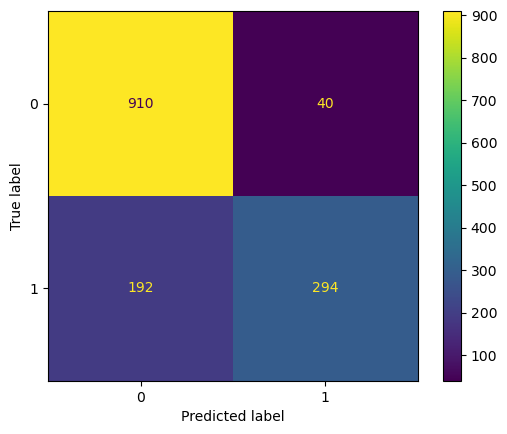

In [13]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_pred=predicted, y_true=ground_truth)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()